<a href="https://colab.research.google.com/github/SuminBae97/PytorchStudy/blob/main/For.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mxnet

     |████████████████████████████████| 47.3 MB 1.5 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
pip install --upgrade mxnet~=1.7 gluonts

     |████████████████████████████████| 2.8 MB 15.5 MB/s 
     |████████████████████████████████| 10.9 MB 44.3 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [3]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [4]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)


<h1>Twitter time series data forecast</h1>
<h1>5분 frequency</h1>

In [5]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


<h1>dataset 호출</h1>
<h1>1시간의 시간간격 데이터</h1>

In [6]:
dataset = get_dataset('m4_hourly',regenerate=True)


saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In [7]:
train = list(dataset.train)
test = list(dataset.test)

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq


In [8]:
to_pandas(train[1]).index[-1]

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


Timestamp('1750-01-30 03:00:00', freq='H')

<h1>Total 414개의 time series, 700개의 time index(1시간 간격)</h1>

In [9]:
len(train), train[0]['target'].shape , len(test), test[0]['target'].shape

(414, (700,), 414, (748,))

In [10]:
to_pandas(train[0])

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
                       ...  
1750-01-29 23:00:00    790.0
1750-01-30 00:00:00    784.0
1750-01-30 01:00:00    752.0
1750-01-30 02:00:00    739.0
1750-01-30 03:00:00    684.0
Freq: H, Length: 700, dtype: float32

In [11]:
to_pandas(test[0])

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
                       ...  
1750-01-31 23:00:00    785.0
1750-02-01 00:00:00    756.0
1750-02-01 01:00:00    719.0
1750-02-01 02:00:00    703.0
1750-02-01 03:00:00    659.0
Freq: H, Length: 748, dtype: float32

<h1>Task:  414개의 time series 데이터의 700 timeindex를 학습 후 48개의 time index forecast</h1>

In [12]:
print(f"Length of forecasting window in test dataset: {len(to_pandas(test[0])) - len(to_pandas(train[0]))}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


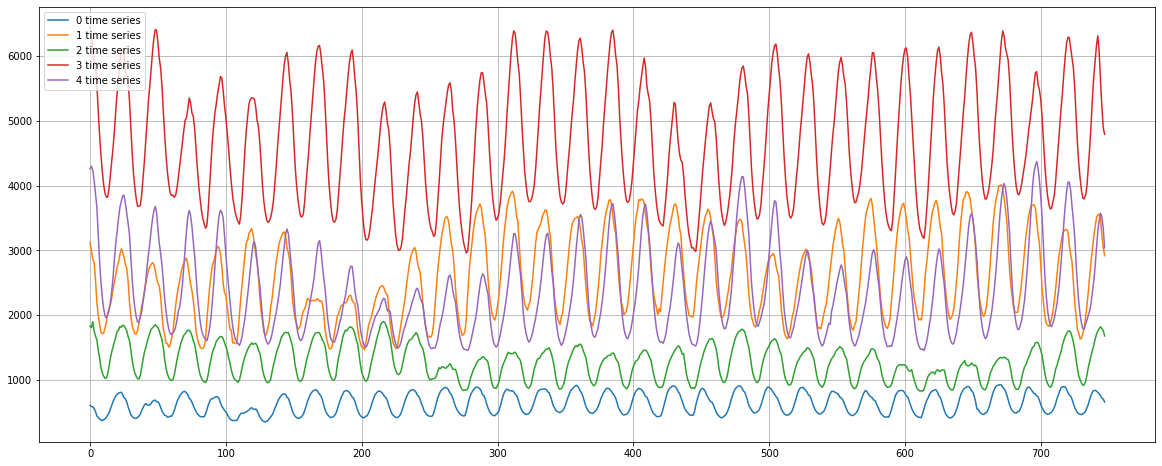

In [13]:
plt.figure(figsize=(20,8))
for i in range(0,5):
    plt.plot(test[i]['target'],label=f'{i} time series')
    #tmp  = to_pandas(train[i])
    
plt.grid(which='both')
plt.legend()

In [14]:
# plt.figure(figsize=(20,8))
# plt.plot(to_pandas(test[10]))
# plt.axvline(to_pandas(train[10]).index[-1],color='r')
# plt.grid(which='both')

def plot_ax(i):
    plt.figure(figsize=(15,4))
    plt.title(f'{i}th time series')
    plt.plot(to_pandas(test[i]))
    plt.axvline(to_pandas(train[i]).index[-1],color='r')
    plt.grid(which='both')



/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


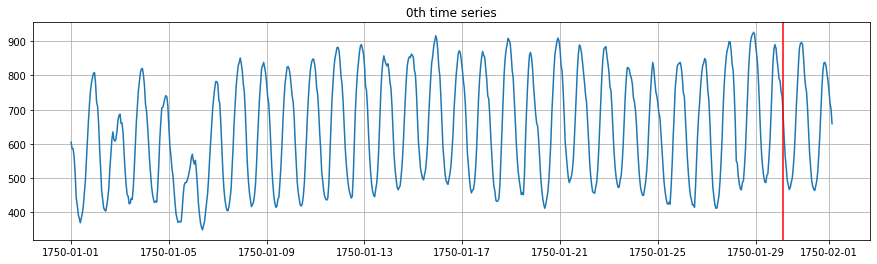

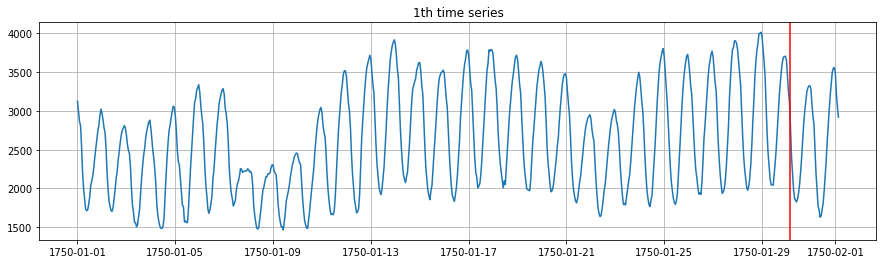

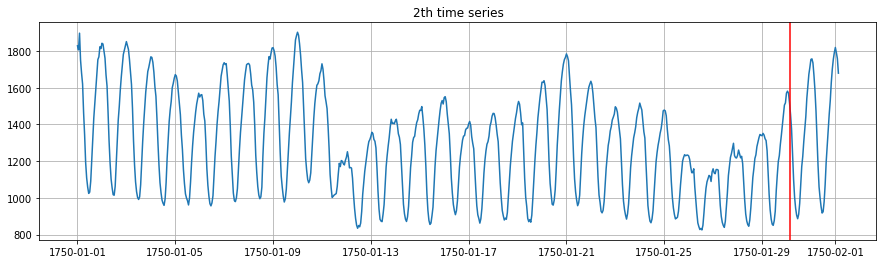

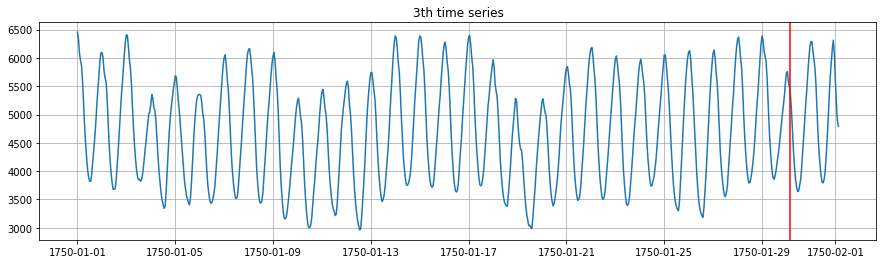

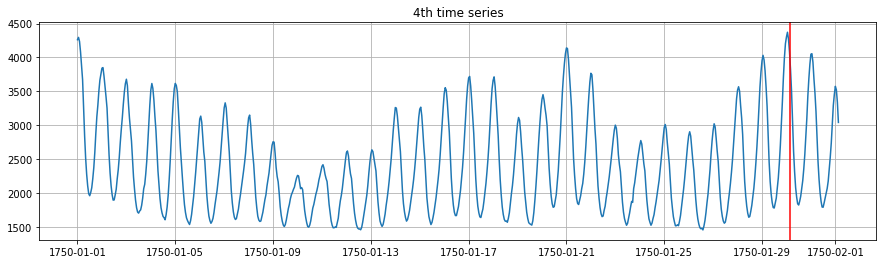

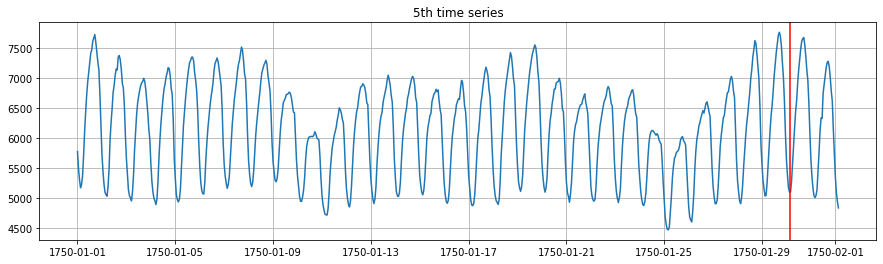

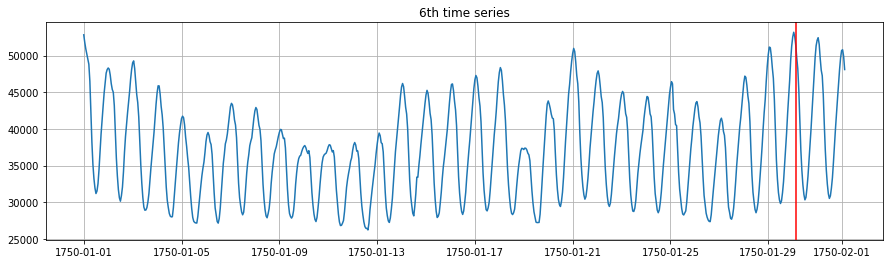

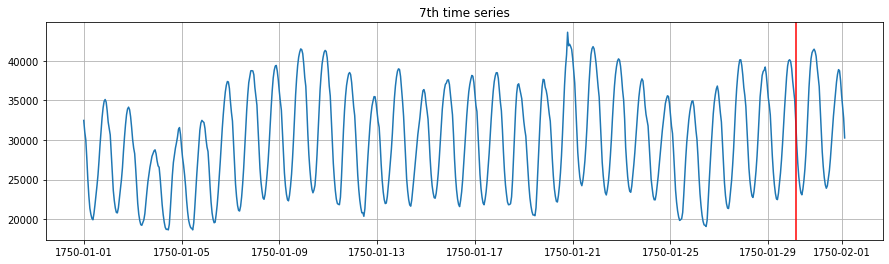

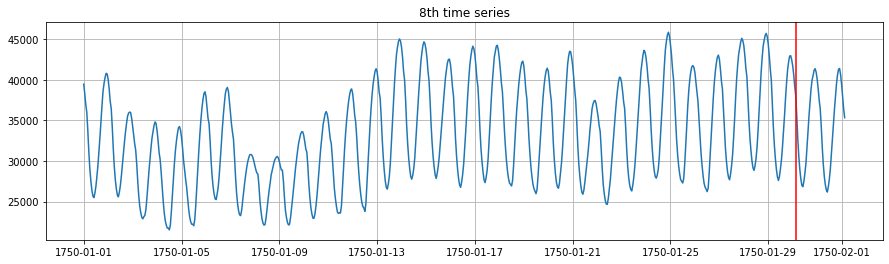

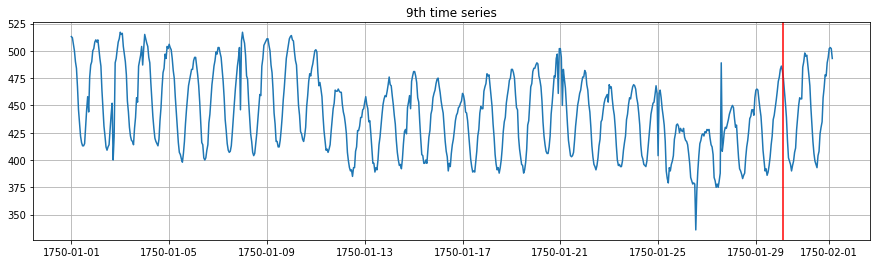

In [15]:
for i in range(10):
    plot_ax(i)

<h1>Modeling</h1>

In [16]:
from gluonts.dataset.common import ListDataset
from gluonts.mx import Trainer
from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions

In [17]:
ar_estimator = DeepAREstimator(
    #예측할 frequency data의 metadata '1h' 호출
    freq = dataset.metadata.freq,
    # 예측 length: 48개의 timeindex 예측
    prediction_length=dataset.metadata.prediction_length, 
    trainer=Trainer(
        epochs=15,
        learning_rate=1e-3,
        num_batches_per_epoch=256
    ),
    context_length=100
)

ar_predictor = ar_estimator.train(dataset.train)


/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed 

In [191]:
# # ar_estimator = DeepAREstimator(
# #     #예측할 frequency data의 metadata '1h' 호출
# #     freq = dataset.metadata.freq,
# #     # 예측 length: 48개의 timeindex 예측
# #     prediction_length=dataset.metadata.prediction_length, 
# #     trainer=Trainer(
# #         epochs=15,
# #         learning_rate=1e-3,
# #         num_batches_per_epoch=256
# #     ),
# #     context_length=100
# # )

# # ar_predictor = ar_estimator.train(dataset.train)


# ar_estimator = DeepAREstimator(
#     #예측할 frequency data의 metadata '1h' 호출
#     freq = dataset.metadata.freq,
#     # 예측 length: 48개의 timeindex 예측
#     prediction_length=dataset.metadata.prediction_length, 
#     trainer=Trainer(
#         epochs=15,
#         learning_rate=1e-3,
#         num_batches_per_epoch=256
#     ),
#     context_length=100,
#     num_layers=5,
#     num_cells=80,
#     cell_type='gru'


# )

# ar_predictor = ar_estimator.train(dataset.train)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed 

In [39]:
ar_estimator = DeepAREstimator(
    #예측할 frequency data의 metadata '1h' 호출
    freq = dataset.metadata.freq,
    # 예측 length: 48개의 timeindex 예측
    prediction_length=dataset.metadata.prediction_length, 
    trainer=Trainer(
        epochs=30,
        learning_rate=1e-3,
        num_batches_per_epoch=256
    ),
    context_length=128
)

ar_predictor = ar_estimator.train(dataset.train)


/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be remov

<h1>총 414개의 time_series 데이터에 대해서 각각 100개씩 샘플링을 진행</h1>

In [40]:
forecast_is,ts_is = make_evaluation_predictions(
    dataset=dataset.test,
    predictor = ar_predictor,
    #각 time serie별로 몇개의 데이터를 샘플링 할것인지
    num_samples = 100
)

In [41]:
forecast = list(forecast_is)
ts = list(ts_is)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


<h1>예측값 형태 및 shape 확인</h1>

In [42]:
len(forecast),len(ts)

(414, 414)

<h1></h1>

In [43]:
forecast[0].samples.shape , ts[0].shape

((100, 48), (748, 1))

In [44]:
forecast[0].samples[0]

array([609.70215, 537.9769 , 528.66156, 508.46738, 482.2896 , 471.28235,
       487.95703, 542.38696, 558.777  , 557.3351 , 614.5573 , 695.86475,
       769.82275, 799.56714, 842.04944, 842.8489 , 853.2564 , 853.8549 ,
       834.44446, 819.3585 , 798.8483 , 803.03595, 775.18506, 732.524  ,
       639.9094 , 541.87103, 533.6453 , 483.3591 , 472.46408, 472.0292 ,
       470.61285, 481.72083, 482.77905, 490.4775 , 559.104  , 645.39496,
       720.70325, 810.27515, 870.02625, 887.1942 , 892.58984, 918.8629 ,
       910.63116, 892.60913, 857.5919 , 847.53864, 825.6065 , 702.85895],
      dtype=float32)

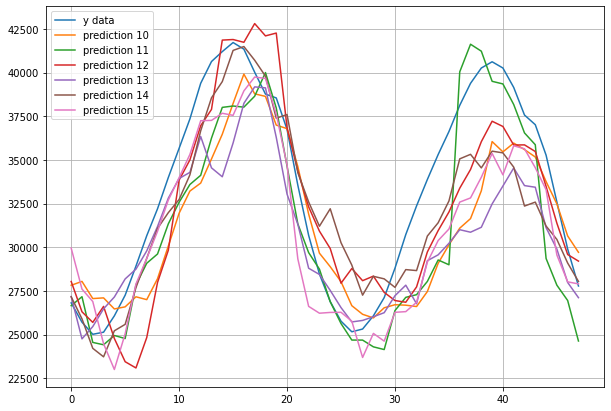

In [45]:
plt.figure(figsize=(10,7))
plt.plot(ts[10][700:].values.reshape(-1,),label='y data')
for i in range(10,16):
    plt.plot(forecast[10].samples[i], label=f'prediction {i}')
plt.legend()
plt.grid(which='both')    

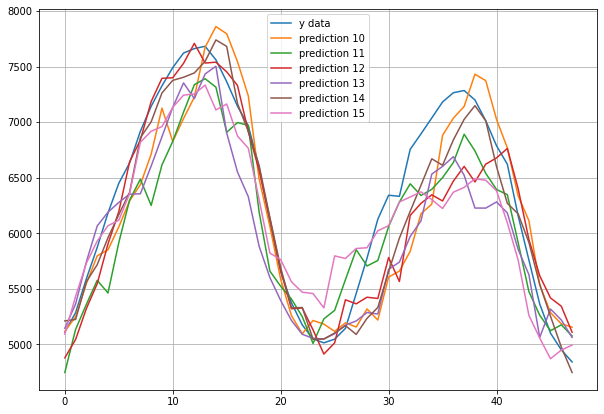

In [46]:
plt.figure(figsize=(10,7))
plt.plot(ts[5][700:].values.reshape(-1,),label='y data')
for i in range(10,16):
    plt.plot(forecast[5].samples[i], label=f'prediction {i}')
plt.legend()
plt.grid(which='both')    

In [47]:
prediction_intervals = (50.0,90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

In [48]:
legend

['observations',
 'median prediction',
 '90.0% prediction interval',
 '50.0% prediction interval']

In [49]:
def plot_prob_forecast(i,ts,forecast):
    plot_length=150
    #신뢰구간
    prediction_interval = (50.0,90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig,ax = plt.subplots(1,1,figsize=(14,6))
    ts[i][-plot_length:].plot(ax=ax)
    forecast[i].plot(prediction_intervals=prediction_intervals,color='g')
    plt.grid(which='both')
    plt.title(f'{i}th item forecast prediction')
    plt.legend(legend,loc='upper left')
    plt.show()

    

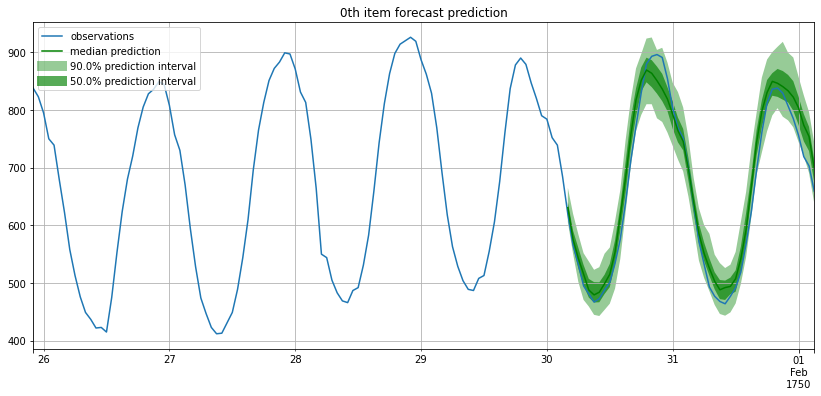

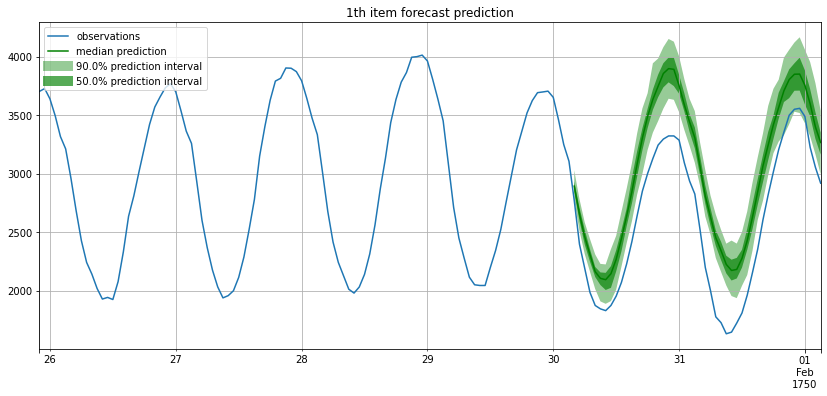

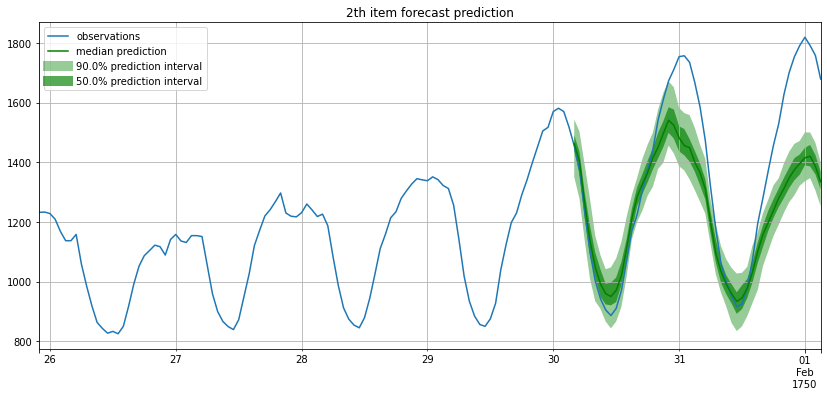

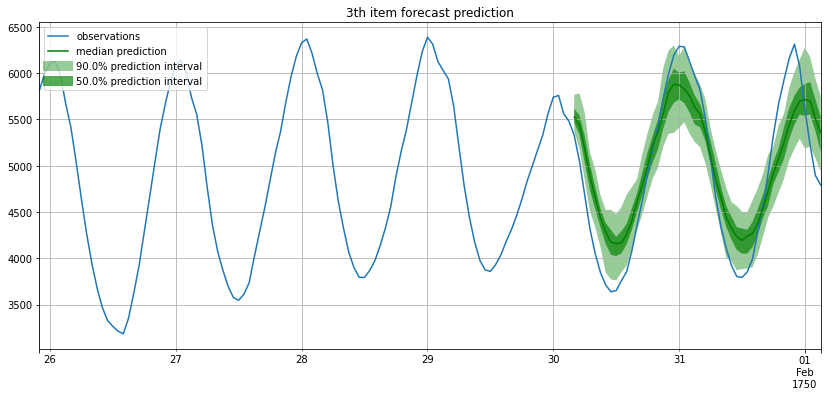

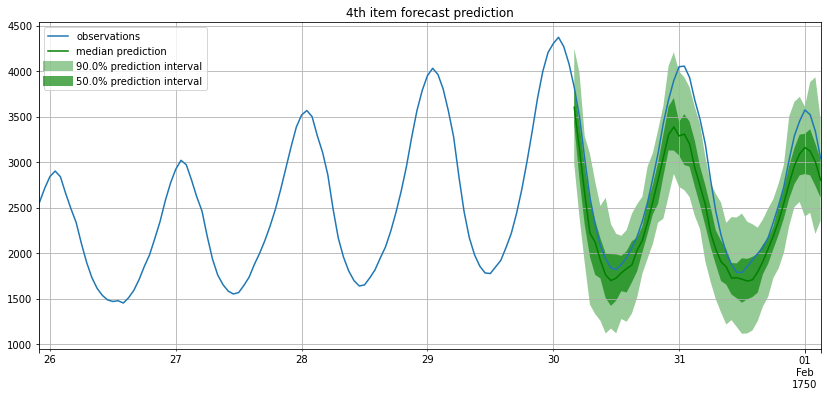

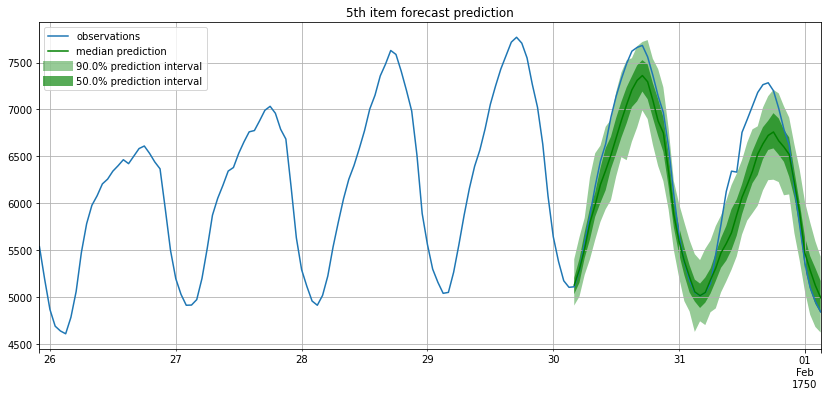

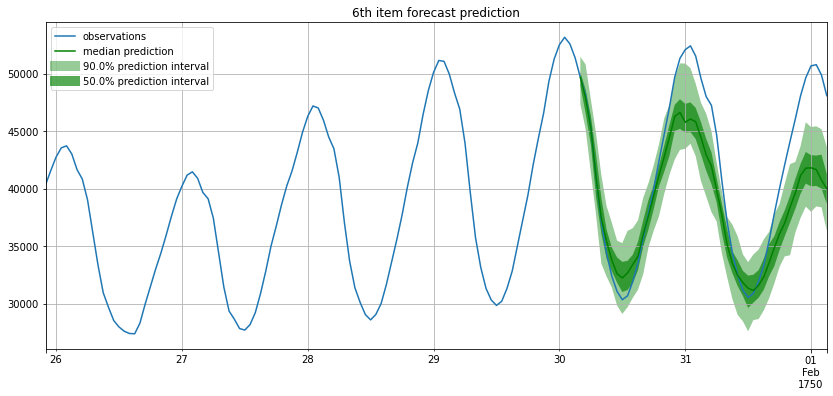

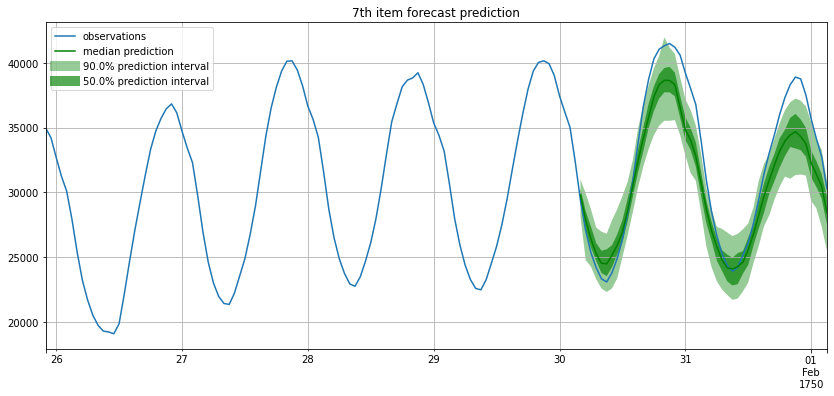

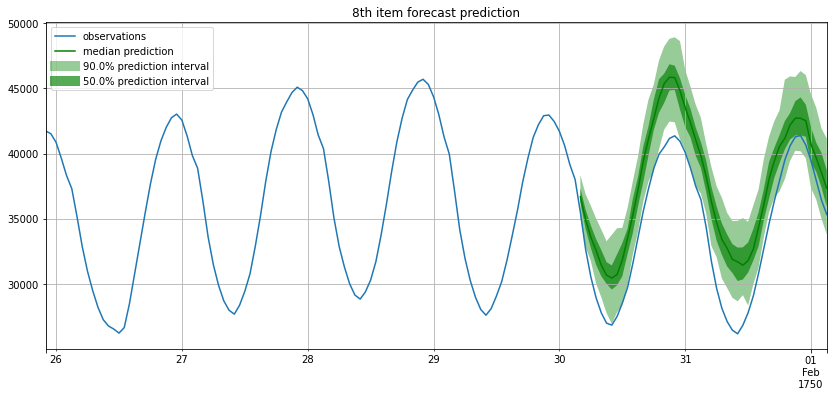

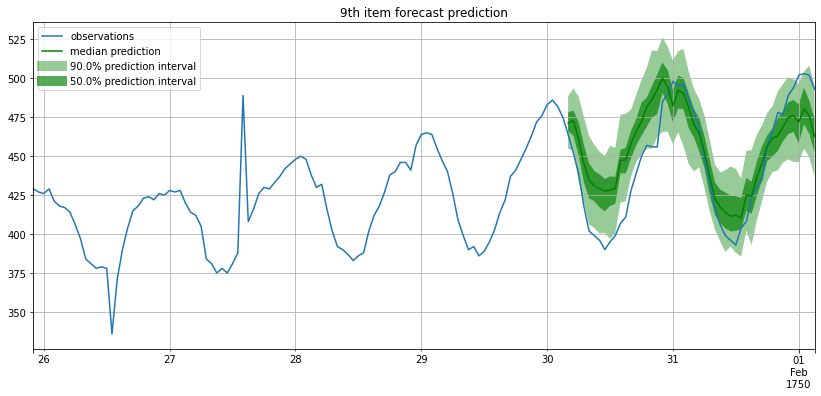

In [50]:
for i in range(10):
    plot_prob_forecast(i,ts,forecast)

In [51]:
from gluonts.evaluation import Evaluator

In [52]:

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(ts), iter(forecast), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 8094.58it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq



In [53]:
print(json.dumps(agg_metrics, indent=2))

{
  "MSE": 9354638.810466526,
  "abs_error": 9526605.59513855,
  "abs_target_sum": 145558863.59960938,
  "abs_target_mean": 7324.822041043147,
  "seasonal_error": 336.9046924038302,
  "MASE": 4.640398229341287,
  "MAPE": 0.15635421332241833,
  "sMAPE": 0.13101295327794726,
  "MSIS": 41.17524827701835,
  "QuantileLoss[0.1]": 3808683.666248226,
  "Coverage[0.1]": 0.3846618357487922,
  "QuantileLoss[0.5]": 9526605.656259537,
  "Coverage[0.5]": 0.687650966183575,
  "QuantileLoss[0.9]": 5511135.047885513,
  "Coverage[0.9]": 0.8897946859903378,
  "RMSE": 3058.5354028466836,
  "NRMSE": 0.41755763972268595,
  "ND": 0.06544847465519864,
  "wQuantileLoss[0.1]": 0.026165934331040266,
  "wQuantileLoss[0.5]": 0.06544847507510428,
  "wQuantileLoss[0.9]": 0.03786189938281644,
  "mean_absolute_QuantileLoss": 6282141.456797759,
  "mean_wQuantileLoss": 0.04315876959632033,
  "MAE_Coverage": 0.16083937198067647,
  "OWA": NaN
}


In [54]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,818.242188,1180.755493,31644.0,659.250000,42.371302,0.580560,0.037667,0.036962,3.115007,269.304498,0.145833,1180.755463,0.812500,555.382678,0.958333
1,1.0,193636.937500,20417.082031,124149.0,2586.437500,165.107988,2.576228,0.176496,0.160045,37.576583,20575.437671,0.979167,20417.081299,1.000000,5770.086914,1.000000
2,2.0,36573.364583,6767.736328,65030.0,1354.791667,78.889053,1.787251,0.091458,0.098208,36.902845,1777.269482,0.000000,6767.736450,0.354167,8143.841187,0.479167
3,3.0,164742.906250,17221.720703,235783.0,4912.145833,258.982249,1.385368,0.076290,0.074444,9.718098,9807.983350,0.458333,17221.720703,0.625000,7989.037402,0.770833
4,4.0,127760.989583,14714.549805,131088.0,2731.000000,200.494083,1.528988,0.104902,0.112018,7.722734,7135.731592,0.000000,14714.549438,0.000000,4717.114062,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,409.0,624.657918,954.329651,5665.0,118.020833,24.726496,0.804071,0.180102,0.186842,5.373389,393.896775,0.000000,954.329659,0.437500,480.065921,0.854167
410,410.0,165.598419,536.512268,4968.0,103.500000,20.766026,0.538251,0.120860,0.123365,4.942289,318.256628,0.020833,536.512249,0.416667,268.612508,0.979167
411,411.0,261.530680,567.122437,3232.0,67.333333,17.477564,0.676012,0.210202,0.185507,4.485732,200.049799,0.187500,567.122412,0.604167,301.348220,0.979167
412,412.0,106.330983,359.633453,2077.0,43.270833,8.636752,0.867498,0.196661,0.179426,5.331077,141.060908,0.062500,359.633474,0.687500,145.721598,0.937500


In [55]:
# from google.colab import drive
# from pathlib import Path
# drive.mount('/content/gdrive')
# #svae
# ar_predictor.serialize(Path('/content/gdrive/My Drive/Colab Notebooks/deepar/'))

# #load
# from gluonts.model.predictor import Predictor
# ar_copied = Predictor.deserialize(Path('/content/gdrive/My Drive/Colab Notebooks/deepar/'))

In [38]:
sum(a)/len(a)

28.0